# The Annotated Encoder-Decoder with Attention

We will implement an Encoder-Decoder with Attention using (Gated) Recurrent Neural Networks, very closely following the original attention-based neural machine translation paper ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) of Bahdanau et al. (2015). 

# Model Architecture

We will model the probability $p(Y\mid X)$ of a target sequence $Y=(y_1, \dots, y_{N})$ given a source sequence $X=(x_1, \dots, x_M)$ directly with a neural network: an Encoder-Decoder.

<img src="images/bahdanau.png" width="636">

#### Encoder 

The encoder reads in the source sentence (*at the bottom of the figure*) and produces a sequence of hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$, one for each source word. These states should capture the meaning of a word in its context of the given sentence.

We will use a bi-directional recurrent neural network (Bi-RNN) as the encoder; a Bi-GRU in particular.

First of all we **embed** the source words. 
We simply look up the **word embedding** for each word in a (randomly initialized) lookup table.
We will denote the word embedding for word $i$ in a given sentence with $\mathbf{x}_i$.
By embedding words, our model may exploit the fact that certain words (e.g. *cat* and *dog*) are semantically similar, and can be processed in a similar way.

Now, how do we get hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$? A forward GRU reads the source sentence left-to-right, while a backward GRU reads it right-to-left.
Each of them follows a simple recursive formula: 
$$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$$
i.e. we obtain the next state from the previous state and the current input word embedding.

The hidden state of the forward GRU at time step $j$ will know what words **precede** the word at that time step, but it doesn't know what words will follow. In contrast, the backward GRU will only know what words **follow** the word at time step $j$. By **concatenating** those two hidden states (*shown in blue in the figure*), we get $\mathbf{h}_j$, which captures word $j$ in its full sentence context.


#### Decoder 

The decoder (*at the top of the figure*) is a GRU with hidden state $\mathbf{s_i}$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_{i}$ (*shown in yellow*).

$$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$$

Here, $\mathbf{y}_{i - 1}$ is the previously generated target word (*not shown*).

At each time step, an **attention mechanism** dynamically selects that part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state with each source hidden state. The result is a context vector $\mathbf{c_i}$ (*shown in yellow*).
Later the attention mechanism is explained in more detail.

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (which applies a [softmax](https://en.wikipedia.org/wiki/Softmax_function)) gives us the probability of the target word $y_i$ for this time step:

$$ p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$$

Because $g$ applies a softmax, it provides a vector the size of the output vocabulary that sums to 1.0: it is a distribution over all target words. During test time, we would select the word with the highest probability for our translation.

Now, for optimization, a [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) is used to maximize the probability of selecting the correct word at this time step. All parameters (including word embeddings) are then updated to maximize this probability.



In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


# Model class


In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

`Generator` class simply projects the pre-output layer ($x$ in the `forward` function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [3]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder

Our encoder is a bi-directional GRU. 

Because we want to process multiple sentences at the same time for speed reasons (it is more effcient on GPU), we need to support **mini-batches**. Sentences in a mini-batch may have different lengths, which means that the RNN needs to unroll further for certain sentences while it might already have finished for others:

```
Example: mini-batch with 3 source sentences of different lengths (7, 5, and 3).
End-of-sequence is marked with a "3" here, and padding positions with "1".

+---------------+
| 4 5 9 8 7 8 3 |
+---------------+
| 5 4 8 7 3 1 1 |
+---------------+
| 5 8 3 1 1 1 1 |
+---------------+
```
You can see that, when computing hidden states for this mini-batch, for sentence #2 and #3 we will need to stop updating the hidden state after we have encountered "3". We don't want to incorporate the padding values (1s).

Luckily, PyTorch has convenient helper functions called `pack_padded_sequence` and `pad_packed_sequence`.
These functions take care of masking and padding, so that the resulting word representations are simply zeros after a sentence stops.

The code below reads in a source sentence (a sequence of word embeddings) and produces the hidden states.
It also returns a final vector, a summary of the complete sentence, by concatenating the first and the last hidden states (they have both seen the whole sentence, each in a different direction). We will use the final vector to initialize the decoder.

In [4]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        #self.rnn = nn.LSTM(input_size, hidden_size, num_layers, 
        #                  batch_first=True, bidirectional=True, dropout=dropout)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)        
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        output, final = self.rnn(packed)
        #output, (final, cell) = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

### Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 

#### Training
In `forward` you can find a for-loop that computes the decoder hidden states one time step at a time. 
Note that, during training, we know exactly what the target words should be! (They are in `trg_embed`.) This means that we are not even checking here what the prediction is! We simply feed the correct previous target word embedding to the GRU at each time step. This is called teacher forcing.

The `forward` function returns all decoder hidden states and pre-output vectors. Elsewhere these are used to compute the loss, after which the parameters are updated.

#### Prediction
For prediction time, for forward function is only used for a single time step. After predicting a word from the returned pre-output vector, we can call it again, supplying it the word embedding of the previously predicted word and the last state.

In [5]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        # self.rnn = nn.LSTM(emb_size + 2*hidden_size, hidden_size, num_layers,
        #                   batch_first=True, dropout=dropout)
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)        
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        #output, (hidden, cell) = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(prev_embed, encoder_hidden, 
                                                           src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            

### Attention                                                                                                                                                                               

At every time step, the decoder has access to *all* source word representations $\mathbf{h}_1, \dots, \mathbf{h}_M$. 
An attention mechanism allows the model to focus on the currently most relevant part of the source sentence.
The state of the decoder is represented by GRU hidden state $\mathbf{s}_i$.
So if we want to know which source word representation(s) $\mathbf{h}_j$ are most relevant, we will need to define a function that takes those two things as input.

Here we use the MLP-based, additive attention that was used in Bahdanau et al.:

<img src="images/attention.png" width="280">


We apply an MLP with tanh-activation to both the current decoder state $\bf s_i$ (the *query*) and each encoder state $\bf h_j$ (the *key*), and then project this to a single value (i.e. a scalar) to get the *attention energy* $e_{ij}$. 

Once all energies are computed, they are normalized by a softmax so that they sum to one: 

$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$

$$\sum_j \alpha_{ij} = 1.0$$ 

The context vector for time step $i$ is then a weighted sum of the encoder hidden states (the *values*):
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

In [6]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
We use learned embeddings to convert the input tokens and output tokens to vectors of dimension `emb_size`.

We will simply use PyTorch's [nn.Embedding](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) class.

## Full Model

Here we define a function from hyperparameters to a full model. 

In [7]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

# Training

This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools 
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as their lengths and masks. 

## Batches and Masking

In [8]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()

## Training Loop
The code below trains the model for 1 epoch (=1 pass through the training data).

In [9]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens

        #scheduler.step() #this is for cosine annealing
        #lr_list.append(scheduler.get_lr()) for cosine annealing

        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

## Training Data and Batching

We will use torch text for batching. This is discussed in more detail below. 

## Optimizer

We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).

We will use $0.0003$ as the learning rate here, but for different problems another learning rate may be more appropriate. You will have to tune that.

## Loss Computation

In [10]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

## Label Smoothing

In [11]:
from torch.autograd import Variable
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

### Printing examples

To monitor progress during training, we will translate a few examples.

We use greedy decoding for simplicity; that is, at each time step, starting at the first token, we choose the one with that maximum probability, and we never revisit that choice. 

In [12]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [13]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break
    

# CNN Text Summarization Task

In [14]:
!pip install git+git://github.com/pytorch/text spacy 
!python -m spacy download en

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-od0a7yzj
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-od0a7yzj
  Running command git submodule update --init --recursive -q
  Created wheel for torchtext: filename=torchtext-0.9.0a0+ec413ff-cp36-cp36m-linux_x86_64.whl size=7132484 sha256=2cbdf5237f9ba092c8fdb17a284189ccac7836d933de9d56fb8dc4d1e2c0ab15
  Stored in directory: /tmp/pip-ephem-wheel-cache-ibtxccvd/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
Successfully built torchtext
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Data Loading

We will load the dataset using torchtext and spacy for tokenization.

For speed we only include short sentences, and we include a word in the vocabulary only if it occurs at least 5 times. In this case we also lowercase the data.

If you have **issues** with torch text in the cell below (e.g. an `ascii` error), try running `export LC_ALL="en_US.UTF-8"` before you start `jupyter notebook`.

In [15]:
#mount google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [16]:
#load data into directory
downloaded = drive.CreateFile({'id':'1vepM2Gabp-3Ca7kN8HqWggEvVCQ0xX75'}) 
downloaded.GetContentFile('CNN_train.csv')

downloaded = drive.CreateFile({'id':'1PG9sAgZH1hLAHPdHTGPzs_qpRHUoaJ32'}) 
downloaded.GetContentFile('CNN_test.csv')

downloaded = drive.CreateFile({'id':'1fNAwFmg3uNhVu2vDgmjIUS7D0VHPTlMB'}) 
downloaded.GetContentFile('CNN_val.csv')

#Enable GPU training 
import torch
USE_GPU = torch.cuda.is_available()
print('USE_GPU={}'.format(USE_GPU))
if USE_GPU:
    print('current_device={}'.format(torch.cuda.current_device()))

USE_GPU=True
current_device=0


In [ ]:
##Colab pro version (increased dataset sizes)

# #load data into directory
# downloaded = drive.CreateFile({'id':'1GUts0SmlAKEc6sujhLTbGv54WmUodZDZ'}) 
# downloaded.GetContentFile('pro_CNN_train.csv')

# downloaded = drive.CreateFile({'id':'1xq8EYdAhqnK_XnnAp8AKAeTjowgFi1Jf'}) 
# downloaded.GetContentFile('pro_CNN_test.csv')

# downloaded = drive.CreateFile({'id':'1pdEP95A33j6ybbVH_jMS3aBbWIIfHdqs'}) 
# downloaded.GetContentFile('pro_CNN_val.csv')

# #Enable GPU training 
# import torch
# USE_GPU = torch.cuda.is_available()
# print('USE_GPU={}'.format(USE_GPU))
# if USE_GPU:
#     print('current_device={}'.format(torch.cuda.current_device()))

In [17]:
import torch
USE_GPU = torch.cuda.is_available()
print('USE_GPU={}'.format(USE_GPU))
if USE_GPU:
    print('current_device={}'.format(torch.cuda.current_device()))

USE_GPU=True
current_device=0


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# For data loading.
from torchtext import data, datasets
from torchtext.data import TabularDataset

if True:
    import spacy
    spacy_en = spacy.load('en')

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    #MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    tv_datafields = [("src", SRC), ("trg", TRG)]
    train_data, valid_data, test_data = TabularDataset.splits(
                  path="/content/drive/Shareddrives/ESE_546_Final_Project/", # the root directory where the data lies
                  train='CNN_train.csv', validation="CNN_val.csv", test = "CNN_test.csv",
                  format='csv',
                  skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                  fields=tv_datafields)

    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

### Let's look at the data

It never hurts to look at your data and some statistics.

In [21]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of Source words (types):", len(src_field.vocab))
    print("Number of Target words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 56321
valid 2222
test 1849 

First training example:
src: ( cnn ) -- police arrested another teen thursday , the sixth suspect jailed in connection with the gang rape of a 15-year - old girl on a northern california high school campus . jose carlos montano , 18 , was arrested on charges of felony rape , rape in concert with force , and penetration with a foreign object , said richmond police lt . mark gagan . montano was arrested thursday evening in san pablo , california , a small town about two miles from the city of richmond , where the crime took place . montano , who was held in lieu of $ 1.3 million bail , is accused of taking part in what police said was a 2½-hour assault on the richmond high school campus . police said as many as 10 people were involved in the rape in a dimly lit back alley at the school , while another 10 people watched without calling 911 . the victim was taken to the hospital in critical condition , but was re

## Iterators
Batching matters a ton for speed. We will use torch text's BucketIterator here to get batches containing sentences of (almost) the same length.

#### Note on sorting batches for RNNs in PyTorch

For effiency reasons, PyTorch RNNs require that batches have been sorted by length, with the longest sentence in the batch first. For training, we simply sort each batch. 
For validation, we would run into trouble if we want to compare our translations with some external file that was not sorted. Therefore we simply set the validation batch size to 1, so that we can keep it in the original order.

In [22]:
train_iter = data.BucketIterator(train_data, batch_size=16, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)
test_iter = data.BucketIterator(test_data, batch_size=1, train=False, sort=False, repeat=False,
                                device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Training the System

Now we train the model. 

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [23]:
#RUN THIS ONE#
def train(model, num_epochs=50, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing
    #criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    criterion = LabelSmoothing(size=len(TRG.vocab), padding_idx=PAD_INDEX, smoothing=0.1)
    criterion.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []
    lr_list=[]

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)

    return dev_perplexities,lr_list

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=2, dropout=0.2)
dev_perplexities, lr_list = train(model, print_every=500, num_epochs=7)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0
Epoch Step: 500 Loss: 290.301147 Tokens per Sec: 3298.560139
Epoch Step: 1000 Loss: 253.781586 Tokens per Sec: 3297.059396
Epoch Step: 1500 Loss: 236.233368 Tokens per Sec: 3339.610301
Epoch Step: 2000 Loss: 212.931931 Tokens per Sec: 3305.293211
Epoch Step: 2500 Loss: 254.945312 Tokens per Sec: 3300.330781
Epoch Step: 3000 Loss: 193.780823 Tokens per Sec: 3257.696823
Epoch Step: 3500 Loss: 195.508759 Tokens per Sec: 3248.061550

Example #1
Src :  ( <unk> - songwriter david crosby hit a jogger with his car sunday evening , a spokesman said . the accident happened in santa <unk> , california , near where crosby lives . crosby was driving at approximately 50 mph when he struck the jogger , according to california highway patrol spokesman don <unk> . the posted speed limit was 55 . the jogger suffered multiple fractures , and was airlifted to a hospital in santa barbara , <unk> said . his injuries are not believed to be life threatening . " mr. crosby was cooperative with authorit

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=2, dropout=0.2)
dev_perplexities = train(model, print_every=500, num_epochs=7)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 500 Loss: 244.978561 Tokens per Sec: 3193.240966
Epoch Step: 1000 Loss: 236.054413 Tokens per Sec: 3247.400482
Epoch Step: 1500 Loss: 234.149109 Tokens per Sec: 3291.939582
Epoch Step: 2000 Loss: 257.293152 Tokens per Sec: 3154.548834
Epoch Step: 2500 Loss: 280.675537 Tokens per Sec: 3245.443559
Epoch Step: 3000 Loss: 315.567047 Tokens per Sec: 3252.859388
Epoch Step: 3500 Loss: 222.645462 Tokens per Sec: 3264.545661

Example #1
Src :  ( <unk> - songwriter david crosby hit a jogger with his car sunday evening , a spokesman said . the accident happened in santa <unk> , california , near where crosby lives . crosby was driving at approximately 50 mph when he struck the jogger , according to california highway patrol spokesman don <unk> . the posted speed limit was 55 . the jogger suffered multiple fractures , and was airlifted to a hospital in santa barbara , <unk> said . his injuries are not believed to be life threatening . " mr. crosby was cooperative with authorities and 

In [ ]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

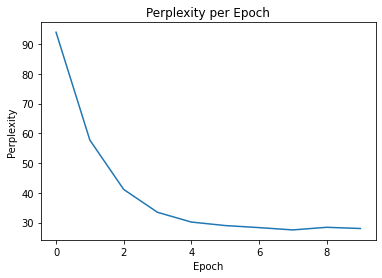

In [ ]:
plot_perplexity(dev_perplexities)

Save model

In [ ]:
# Save
torch.save(model.cpu().state_dict(), "enc_dec_model.pth")

In [ ]:
from google.colab import files
files.download('enc_dec_model.pth')

In [ ]:
#save the list for the LR. SANJ RUN THIS
torch.save(lr_list,'exponential_decay_lr_list')

In [ ]:
#RUN
files.download('exponential_decay_lr_list')

Load model

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
!ls /content/gdrive

MyDrive  Shareddrives


In [26]:
# Load
path = "/content/gdrive/Shareddrives/ESE_546_Final_Project/"
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=2, dropout=0.2)
model.load_state_dict(torch.load(path + "small_lrls_model.pth"))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(768, 256, num_layers=2, batch_first=True, dropout=0.2)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (pre_output_layer): Linear(in_features=1024, out_features=256, bias=False)
  )
  (src_embed): Embedding(61083, 256)
  (trg_embed): Embedding(22080, 256)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=22080, bias=False)
  )
)

## Prediction and Evaluation


**Now we summarize the validation set!**

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
# we will still need to convert the indices to actual words!
hypotheses[0]

array([   6,  173,   15,  108,    8,    6,    0,  568,    4,    5,    6,
        968,   15,   48,   37,  924,    9,   36,  273, 1520,    4,    5,
         23,   15, 1653])

In [ ]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

['the',
 'video',
 'was',
 'killed',
 'in',
 'the',
 '<unk>',
 'accident',
 '.',
 '\n',
 'the',
 'truck',
 'was',
 'not',
 'been',
 'able',
 'to',
 'be',
 'life',
 'threatening',
 '.',
 '\n',
 'he',
 'was',
 'hospitalized']

In [ ]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

2222
the video was killed in the <unk> accident . 
 the truck was not been able to be life threatening . 
 he was hospitalized


## Attention Visualization

We can also visualize the attention scores of the decoder.

In [ ]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots(figsize=(15,20))
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

src ['(', 'cnn)singer', '-', 'songwriter', 'david', 'crosby', 'hit', 'a', 'jogger', 'with', 'his', 'car', 'sunday', 'evening', ',', 'a', 'spokesman', 'said', '.', 'the', 'accident', 'happened', 'in', 'santa', 'ynez', ',', 'california', ',', 'near', 'where', 'crosby', 'lives', '.', 'crosby', 'was', 'driving', 'at', 'approximately', '50', 'mph', 'when', 'he', 'struck', 'the', 'jogger', ',', 'according', 'to', 'california', 'highway', 'patrol', 'spokesman', 'don', 'clotworthy', '.', 'the', 'posted', 'speed', 'limit', 'was', '55', '.', 'the', 'jogger', 'suffered', 'multiple', 'fractures', ',', 'and', 'was', 'airlifted', 'to', 'a', 'hospital', 'in', 'santa', 'barbara', ',', 'clotworthy', 'said', '.', 'his', 'injuries', 'are', 'not', 'believed', 'to', 'be', 'life', 'threatening', '.', '"', 'mr.', 'crosby', 'was', 'cooperative', 'with', 'authorities', 'and', 'he', 'was', 'not', 'impaired', 'or', 'intoxicated', 'in', 'any', 'way', '.', 'mr.', 'crosby', 'did', 'not', 'see', 'the', 'jogger', 'be

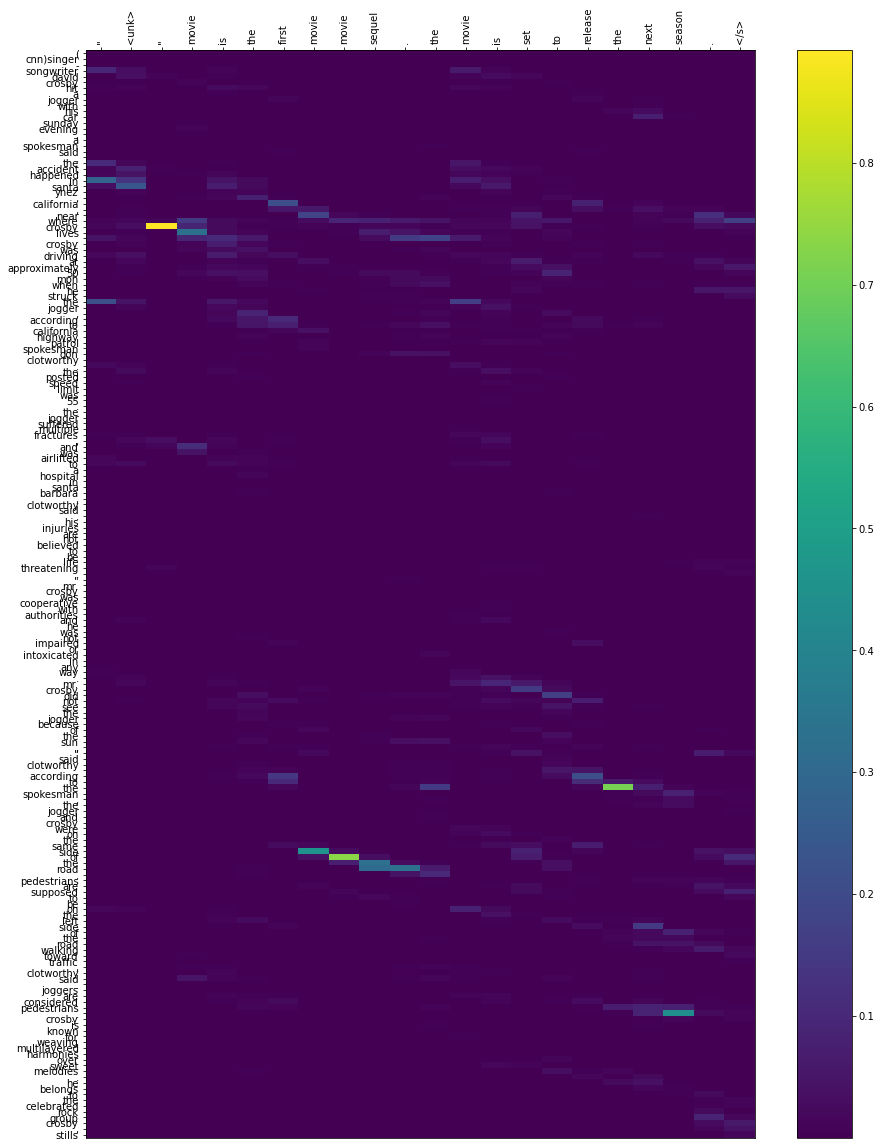

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 0
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

src ['(', 'cnn)more', 'than', '100', 'schools', 'in', 'pakistan', 'have', 'been', 'renamed', 'in', 'honor', 'of', 'the', 'children', 'killed', 'in', 'a', 'taliban', 'siege', 'at', 'a', 'peshawar', 'school', 'last', 'year', '.', 'according', 'to', 'the', 'provincial', 'government', 'of', 'khyber', 'pakhtunkhwa', ',', '107', 'local', 'schools', 'now', 'bear', 'the', 'name', 'of', 'a', 'student', 'killed', 'during', 'the', 'december', '16', 'attack', 'on', 'the', 'army', 'public', 'school', '.', 'government', 'spokesman', 'mushtaq', 'ghani', 'told', 'cnn', 'that', 'the', 'gesture', 'was', 'a', 'way', 'to', 'remember', 'the', 'bravery', 'of', 'the', 'students', 'who', 'were', 'taking', 'exams', 'in', 'an', 'auditorium', ' ', 'when', 'taliban', 'militants', 'strapped', 'with', 'explosives', 'laid', 'siege', '.', 'some', 'six', 'hours', 'later', ',', '145', 'were', 'dead', ',', '132', 'of', 'them', 'children', ',', 'according', 'to', 'authorities', '.', 'in', 'february', ',', 'pakistani', 'a

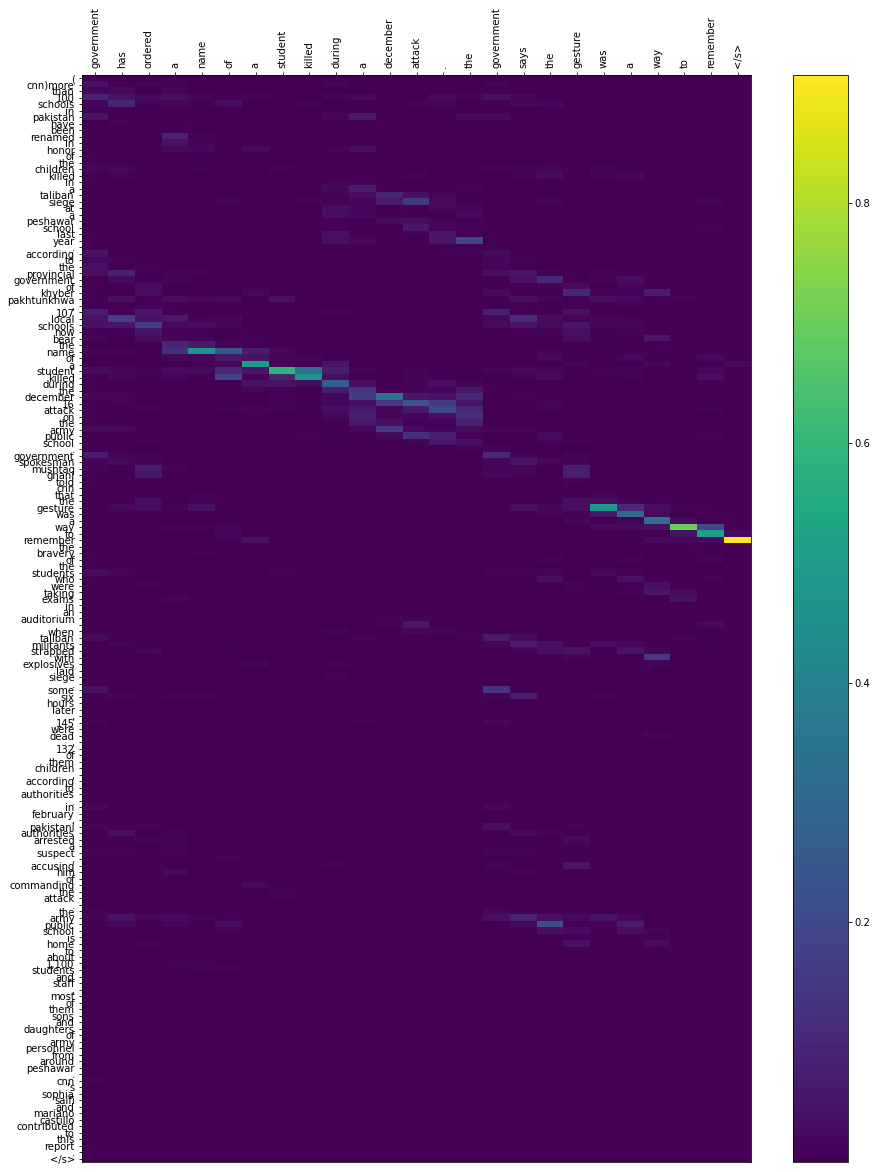

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

# ROUGE scores

In [27]:
!pip install rouge-score

In [28]:
from rouge_score import rouge_scorer

def calc_rouge(scorer, sources, predictions):
  rouge1 = 0
  rouge2 = 0
  rougeL = 0
  for i in range(len(sources)):
    scores = scorer.score(sources[i], predictions[i])
    rouge1+=scores['rouge1'][2]
    rouge2+=scores['rouge2'][2]
    rougeL+=scores['rougeL'][2]
  return rouge1/len(sources), rouge2/len(sources), rougeL/len(sources)

In [30]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
sources = ['My name is Bob', "Hello mom"]
predictions = ['They call me Bob', "Hi there, mother"]
calc_rouge(scorer, sources, predictions)

(0.125, 0.0, 0.125)

Rouge scores fail to encapsulate meaning

# Calculate ROUGE scores on test set

In [31]:
def beam_search_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None, beam_width=3):
    """Beam search to decode the summaries."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    sequences = [[list(), 0.0]]
    attention_scores = []
    hidden = None

    for i in range(max_len):
      all_candidates = []
      if i==0: #on first iteration, we only use the sos_index to feed into the decoder
          with torch.no_grad():
              out, hidden, pre_output = model.decode(encoder_hidden, encoder_final, src_mask,
                                                    prev_y, trg_mask, hidden)
              prob = model.generator(pre_output[:, -1])
              top_hiddens = [hidden]*beam_width #these will all be the same for first iteration

          attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
          seq, score = sequences[i]
          scores, next_words = torch.topk(prob, k=beam_width, dim=1) #scores are the log(prob) values and next_words are the indices
          scores, next_words = scores.data[0], next_words.data[0]
          for j in range(len(next_words)):
            candidates = [seq + [next_words[j].cpu().item()], score + scores[j].item()]
            all_candidates.append(candidates) #sequences are length 3 at the end of this

          ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
          sequences = ordered[:beam_width]

      else: #after first iteration, we have k words to use as prior distribution in order to decode next word
        hidden_states = []
        for k in range(len(sequences)):          
            with torch.no_grad():
                use_hidden = top_hiddens[k]
                prev_y = torch.ones(1, 1).type_as(src).fill_(next_words[k].item())
                out, hidden, pre_output = model.decode(encoder_hidden, encoder_final, src_mask,
                                                      prev_y, trg_mask, use_hidden)   
                prob = model.generator(pre_output[:, -1])
                hidden_states.append(hidden)

            attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
            seq, score = sequences[k]
            new_scores, new_next_words = torch.topk(prob, k=beam_width, dim=1) #next words are the indices
            new_scores, new_next_words = new_scores.data[0], new_next_words.data[0] #index into double list
            for j in range(len(new_scores)):
                candidates = [seq + [new_next_words[j].cpu().item()], score + new_scores[j].item()]
                all_candidates.append(candidates)

        #prune ouputs to include top k probabilities
        ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
        sequences = ordered[:beam_width]

        #create hidden states to use in next time step based off the word use to achieve the best next word (likelihood, which is the second
        # to last number in the sequences structure)
        top_hiddens = []
        for h in range(len(next_words)):
          idx = next_words.tolist().index(sequences[h][0][-2])
          top_hiddens.append(hidden_states[idx])

        #create next words to be used as prev_y in decoder 
        next_words = []
        for w in range(len(sequences)):
          next_words.append(sequences[w][0][-1])
        next_words = torch.Tensor(next_words)
    
    #at end of loop prune to the single best sequence found through beam search. This will be the first sequence since we have been ordering them
    output = np.array(sequences[0][0])
        
    # cut off everything starting from </s>
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

Test out greedy decode vs. beam

In [32]:
#Beam search

hypotheses = []
alphas = []  # save the last attention scores
for batch in test_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = beam_search_decode(model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
                                       sos_index=TRG.vocab.stoi[SOS_TOKEN],
                                       eos_index=TRG.vocab.stoi[EOS_TOKEN],
                                       beam_width=6)
  hypotheses.append(pred)
  alphas.append(attention)

#convert hypotheses into sentences
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses = [" ".join(x) for x in hypotheses]

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
#Greedy decoding results (k=1)
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Rouge 1 Score:  0.25270702089071645
Rouge 2 Score:  0.07569303775132512
Rouge L Score:  0.19548488131958094


In [ ]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 2")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 2
Rouge 1 Score:  0.26198364170906324
Rouge 2 Score:  0.08806306115961755
Rouge L Score:  0.20350317649185543


In [ ]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 3")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 3
Rouge 1 Score:  0.2671505670064548
Rouge 2 Score:  0.09469638247392158
Rouge L Score:  0.20739410341317083


In [ ]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 4")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 4
Rouge 1 Score:  0.26824288015493625
Rouge 2 Score:  0.09663463816404481
Rouge L Score:  0.20888597941913337


In [ ]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 5")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 5
Rouge 1 Score:  0.2701228480494834
Rouge 2 Score:  0.09810189358062363
Rouge L Score:  0.2108817576046179


In [ ]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 6")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 6
Rouge 1 Score:  0.27080369283949324
Rouge 2 Score:  0.09931233604159108
Rouge L Score:  0.2117791035888489


With label smoothing results:

In [33]:
references = [" ".join(example.trg) for example in test_data]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougeL = calc_rouge(scorer, references, hypotheses)
print("Beam Search Results k = 6")
print("Rouge 1 Score: ", rouge1)
print("Rouge 2 Score: ", rouge2)
print("Rouge L Score: ", rougeL)

Beam Search Results k = 6
Rouge 1 Score:  0.27657785778886923
Rouge 2 Score:  0.10563689216530285
Rouge L Score:  0.2149177700296959


Create plot

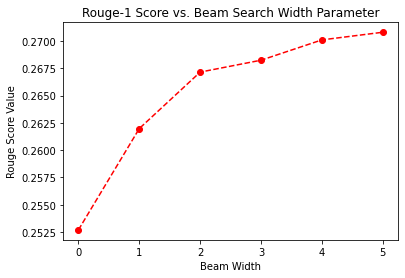

In [ ]:
rouge_1 = [0.2527, 0.26198, 0.26715, 0.26824, 0.2701, 0.2708]
rouge_2 = [0.07569303775132512, 0.08806306115961755, 0.09469638247392158, 0.09663463816404481, 0.09810189358062363, 0.09931233604159108]
rouge_L = [0.19548488131958094, 0.20350317649185543, 0.20739410341317083, 0.20888597941913337, 0.2108817576046179, 0.2117791035888489]

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(rouge_1, 'ro--')
plt.xlabel("Beam Width")
plt.ylabel("Rouge Score Value")
plt.title("Rouge-1 Score vs. Beam Search Width Parameter")
plt.show()

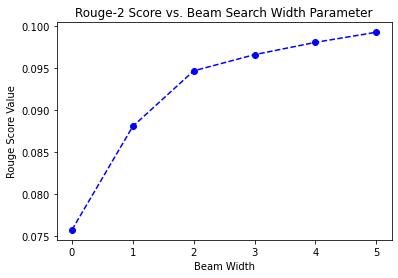

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(rouge_2, 'bo--')
plt.xlabel("Beam Width")
plt.ylabel("Rouge Score Value")
plt.title("Rouge-2 Score vs. Beam Search Width Parameter")
plt.show()

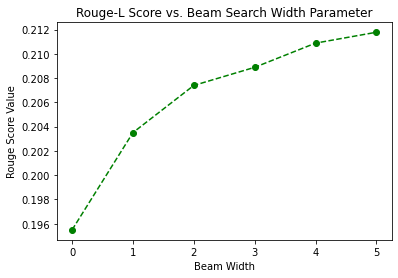

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(rouge_L, 'go--')
plt.xlabel("Beam Width")
plt.ylabel("Rouge Score Value")
plt.title("Rouge-L Score vs. Beam Search Width Parameter")
plt.show()

Save summaries to csv for question-answering scores

In [ ]:
import pandas as pd
df = pd.DataFrame(np.array(hypotheses).reshape(-1,1), columns=['predicted_summary'])
df['original_summary'] = np.array(references).reshape(-1,1)
df.head()

,predicted_summary,original_summary
0,"comic book is expected to release the <unk> "" ...",michelle maclaren is no longer set to direct t...
1,a roadside bombing kills the taliban commander...,"saudi general says more than 1,200 airstrikes ..."
2,the <unk> <unk> was a former student in the <u...,six people taken hostage in a kosher market si...
3,police say they were released in the incident ...,police questioned the group about an alleged a...
4,"<unk> <unk> , 26 , allegedly stole a woman wit...","former tsa agent daniel boykin , 33 , videotap..."


In [ ]:
df.to_csv("predicted_summaries.csv")
from google.colab import files
files.download('predicted_summaries.csv')

In [34]:
import pandas as pd
df = pd.DataFrame(np.array(hypotheses).reshape(-1,1), columns=['predicted_summary'])
df['original_summary'] = np.array(references).reshape(-1,1)
df.head()

,predicted_summary,original_summary
0,""" <unk> "" <unk> is the first "" movie "" movie ""...",michelle maclaren is no longer set to direct t...
1,new : the u.s. health ministry says the death ...,"saudi general says more than 1,200 airstrikes ..."
2,paris saint - <unk> <unk> was arrested in a po...,six people taken hostage in a kosher market si...
3,"<unk> <unk> , 21 , was shot in the <unk> by a ...",police questioned the group about an alleged a...
4,"<unk> <unk> , 29 , was arrested last month whe...","former tsa agent daniel boykin , 33 , videotap..."


In [37]:
df.to_csv("final_model_predicted_summaries.csv")
from google.colab import files
files.download('final_model_predicted_summaries.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This notebook is an adaptation from the following source:

> J Bastings. 2018. The Annotated Encoder-Decoder with Attention. https://bastings.github.io/annotated_encoder_decoder/

Or use the following `Bibtex`:
```
@misc{bastings2018annotated,
  title={The Annotated Encoder-Decoder with Attention},
  author={Bastings, J.},
  journal={https://bastings.github.io/annotated\_encoder\_decoder/},
  year={2018}
}```